# CSE4214 – Pattern Recognition Lab
## Experiment No 2: Implementing the Perceptron Algorithm for Finding the Weights of a Linear Discriminant Function
**Student ID:** 20220104098

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

---
## Task 1: Load Data & Plot Sample Points

In [2]:
import io

# ── Data embedded inline (from train-perceptron.txt) ────────────────────────
raw = """1 1 1
1 -1 1
4 5 1
2 2.5 2
0 2 2
2 3 2"""

# Alternatively, if the file IS available, comment the lines above and use:
# data = np.loadtxt('train-perceptron.txt')
data = np.loadtxt(io.StringIO(raw))

X = data[:, :2]          # features (x1, x2)
labels = data[:, 2]      # class labels (1 or 2)

class1 = X[labels == 1]  # ω1
class2 = X[labels == 2]  # ω2

print("Class 1 (ω1):", class1)
print("Class 2 (ω2):", class2)

Class 1 (ω1): [[ 1.  1.]
 [ 1. -1.]
 [ 4.  5.]]
Class 2 (ω2): [[2.  2.5]
 [0.  2. ]
 [2.  3. ]]


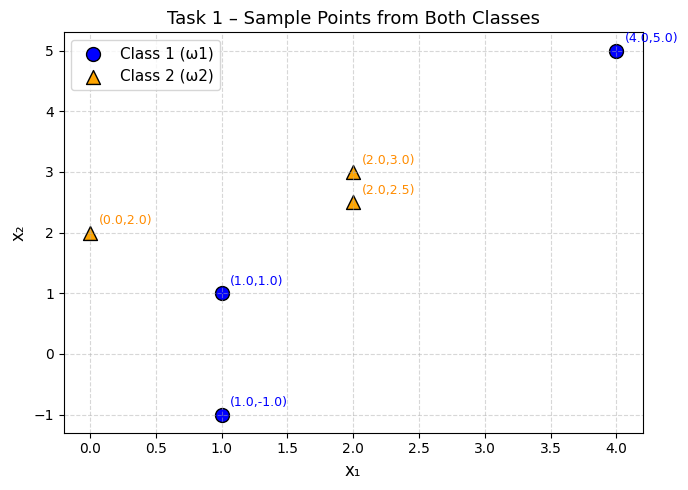


Observation: The two classes are NOT linearly separable in 2D space, so we need to map them to a higher-dimensional feature space.


In [3]:
# ── Plot ─────────────────────────────────────────────────────────────────────
plt.figure(figsize=(7, 5))
plt.scatter(class1[:, 0], class1[:, 1], color='blue',   marker='o', s=100,
            label='Class 1 (ω1)', edgecolors='black')
plt.scatter(class2[:, 0], class2[:, 1], color='orange', marker='^', s=100,
            label='Class 2 (ω2)', edgecolors='black')

for i, (x1, x2) in enumerate(class1):
    plt.annotate(f'({x1},{x2})', (x1, x2), textcoords='offset points',
                 xytext=(6, 6), fontsize=9, color='blue')
for i, (x1, x2) in enumerate(class2):
    plt.annotate(f'({x1},{x2})', (x1, x2), textcoords='offset points',
                 xytext=(6, 6), fontsize=9, color='darkorange')

plt.xlabel('x₁', fontsize=12)
plt.ylabel('x₂', fontsize=12)
plt.title('Task 1 – Sample Points from Both Classes', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('task1_plot.png', dpi=150)
plt.show()
print("\nObservation: The two classes are NOT linearly separable in 2D space,"
      " so we need to map them to a higher-dimensional feature space.")

---
## Task 2: 2nd-Order Polynomial Mapping & Class Normalization

Each 2-D point **x = [x₁, x₂]** is mapped to a 6-D vector:

$$\mathbf{y} = \phi(\mathbf{x}) = [x_1^2,\; x_2^2,\; x_1 x_2,\; x_1,\; x_2,\; 1]^T$$

Then we **normalise Class 2** by negating its vectors so that every correctly-classified sample satisfies $ \mathbf{a}^T\tilde{\mathbf{y}} > 0 $.

In [ ]:
def phi(x):
    """Map 2-D point x=[x1,x2] to 6-D augmented feature vector."""
    x1, x2 = x[0], x[1]
    return np.array([x1**2, x2**2, x1*x2, x1, x2, 1.0])

# High-dimensional vectors for each class
Y1 = np.array([phi(x) for x in class1])   # Class 1  (kept as-is)
Y2 = np.array([phi(x) for x in class2])   # Class 2  (will be negated)

# Class Normalization: negate Class 2 vectors
Y2_norm = -Y2

# Combined normalised training set
Y_train = np.vstack([Y1, Y2_norm])

print("High-dimensional vectors (Class 1):")
for i, y in enumerate(Y1):
    print(f"  y{i+1,1} = {y}")

print("\nHigh-dimensional vectors (Class 2, NEGATED for normalisation):")
for i, y in enumerate(Y2_norm):
    print(f" -y{i+1,2} = {y}")

### Why do we need to map to high dimension? (Task 2a)

> The original 2-D data points are **not linearly separable**, meaning no straight line can perfectly separate Class 1 from Class 2 in the original feature space.  
> By applying the second-order polynomial mapping $\phi$, we embed the points into a 6-D space where a **hyperplane** (linear boundary in 6-D) corresponds to a **second-order curve** in the original 2-D space.  
> This gives the perceptron the expressive power needed to find a valid separating boundary, which is a direct application of the **kernel trick** / Cover's theorem.

---
## Task 3: Perceptron Algorithm

### Weight Update Rule
$$\mathbf{w}(i+1) = \begin{cases} \mathbf{w}(i) + \alpha\,\tilde{\mathbf{y}}_m^{(k)} & \text{if } \mathbf{w}^T(i)\,\tilde{\mathbf{y}}_m^{(k)} \leq 0 \\ \mathbf{w}(i) & \text{otherwise} \end{cases}$$

In [ ]:
MAX_ITER = 10000   # safety cap to avoid infinite loops

# ── One-at-a-Time Perceptron ─────────────────────────────────────────────────
def perceptron_one_at_a_time(Y, w_init, alpha, max_iter=MAX_ITER):
    """
    One-at-a-time perceptron.
    Returns (final_weight, num_iterations).
    num_iterations = number of complete passes (epochs) until convergence.
    """
    w = w_init.copy().astype(float)
    n = len(Y)

    for iteration in range(1, max_iter + 1):
        misclassified = 0
        for y in Y:
            if np.dot(w, y) <= 0:          # misclassified
                w = w + alpha * y
                misclassified += 1
        if misclassified == 0:             # converged
            return w, iteration

    return w, max_iter   # did not converge within max_iter


# ── Many-at-a-Time (Batch) Perceptron ────────────────────────────────────────
def perceptron_many_at_a_time(Y, w_init, alpha, max_iter=MAX_ITER):
    """
    Batch (many-at-a-time) perceptron.
    Returns (final_weight, num_iterations).
    """
    w = w_init.copy().astype(float)

    for iteration in range(1, max_iter + 1):
        misclassified_sum = np.zeros_like(w, dtype=float)
        count = 0
        for y in Y:
            if np.dot(w, y) <= 0:          # misclassified
                misclassified_sum += y
                count += 1
        if count == 0:                     # converged
            return w, iteration
        w = w + alpha * misclassified_sum  # single update per iteration

    return w, max_iter


print("Perceptron functions defined successfully.")
print(f"Training set shape: {Y_train.shape}")

In [ ]:
# ── Quick demonstration with alpha=0.8, all-ones init ────────────────────────
np.random.seed(42)
dim = Y_train.shape[1]

w_ones = np.ones(dim)
w_demo, iters_demo = perceptron_one_at_a_time(Y_train, w_ones, alpha=0.8)
print(f"One-at-a-time (α=0.8, all-ones init): converged in {iters_demo} iterations")
print(f"Final weight vector: {np.round(w_demo, 4)}")

# Verify all training samples are correctly classified
preds = [np.dot(w_demo, y) for y in Y_train]
print("g(y) scores:", [round(p, 3) for p in preds])
print("All correctly classified:", all(p > 0 for p in preds))

---
## Task 4: Comparison Table & Bar Charts
Three initial weight vectors × 10 learning rates × 2 algorithms = 60 experiments

In [ ]:
np.random.seed(42)
dim = Y_train.shape[1]

alphas = np.round(np.arange(0.1, 1.1, 0.1), 1)

init_configs = {
    'All Ones' : np.ones(dim),
    'All Zeros': np.zeros(dim),          # NOTE: zero init rarely converges
    'Random'   : np.random.uniform(-1, 1, dim),
}

results = {}   # {init_name: {'one': [iters], 'batch': [iters]}}

for name, w_init in init_configs.items():
    one_iters   = []
    batch_iters = []
    for alpha in alphas:
        _, n1 = perceptron_one_at_a_time  (Y_train, w_init, alpha)
        _, nb = perceptron_many_at_a_time (Y_train, w_init, alpha)
        one_iters.append(n1)
        batch_iters.append(nb)
    results[name] = {'One-at-a-Time': one_iters, 'Many-at-a-Time': batch_iters}

print("Experiments complete.")

In [ ]:
# ── Print formatted tables ────────────────────────────────────────────────────
for name, res in results.items():
    df = pd.DataFrame({
        'Alpha (Learning Rate)' : alphas,
        'One-at-a-Time (iters)' : res['One-at-a-Time'],
        'Many-at-a-Time (iters)': res['Many-at-a-Time'],
    })
    df['Alpha (Learning Rate)'] = df['Alpha (Learning Rate)'].map(lambda x: f'{x:.1f}')
    print(f"\n{'='*55}")
    print(f"  Initial Weight Vector: {name}")
    print(f"{'='*55}")
    print(df.to_string(index=False))
    print(f"{'='*55}")

In [ ]:
# ── Bar Charts ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

x_pos = np.arange(len(alphas))
bar_w = 0.35

colors = {'One-at-a-Time': '#1f77b4', 'Many-at-a-Time': '#ff7f0e'}

for ax, (name, res) in zip(axes, results.items()):
    one_vals   = res['One-at-a-Time']
    batch_vals = res['Many-at-a-Time']

    bars1 = ax.bar(x_pos - bar_w/2, one_vals,   bar_w,
                   label='One at a time',  color=colors['One-at-a-Time'],  alpha=0.9)
    bars2 = ax.bar(x_pos + bar_w/2, batch_vals, bar_w,
                   label='Many at a time', color=colors['Many-at-a-Time'], alpha=0.9)

    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'{a:.1f}' for a in alphas], fontsize=9)
    ax.set_xlabel('Learning Rate (α)', fontsize=11)
    ax.set_ylabel('No. of Iterations', fontsize=11)
    ax.set_title(f'Initial Weight: {name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

fig.suptitle('Perceptron Convergence Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('task4_bar_charts.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Discussion

### (a) Why do we map to a higher dimension?
The original 2-D data is **not linearly separable** — no single straight line can separate Class 1 from Class 2.  
By applying the second-order mapping $\phi(\mathbf{x}) = [x_1^2,\;x_2^2,\;x_1 x_2,\;x_1,\;x_2,\;1]^T$, we embed the points into a 6-dimensional space where a **linear hyperplane** in that space corresponds to a **second-order polynomial boundary** in the original 2-D space. This increases the model's capacity to separate classes that are not linearly separable in the input space, a key motivation behind kernel methods and the perceptron with feature mappings.

### (b) How many updates before convergence?
The number of updates depends on three factors:

1. **Initial weight vector** – All-zeros initialisation sometimes stalls convergence (the update rule adds a scaled copy of the misclassified sample, so a zero start is fine, but with certain data it can cycle).  Random initialisation often yields fewer iterations because it starts closer to a solution.  All-ones is a neutral starting point.

2. **Learning rate α** – Very small α (e.g. 0.1) means tiny steps → more iterations.  Very large α (e.g. 1.0) can overshoot → oscillation and more iterations.  A moderate value (≈ 0.5) typically gives the fastest convergence for this dataset.

3. **Strategy** – *One-at-a-time* updates the weight immediately after each misclassification, so it can fix errors faster within an epoch.  *Many-at-a-time* (batch) performs only one update per epoch using the sum of all misclassified vectors, which is more stable but may need more epochs.

As seen in the tables above, iteration counts generally range from a few to a few hundred, consistent with the tutorial's expectation.